In [ ]:
pip install scikit-learn==1.5.2

In [ ]:
pip install category-encoders

In [ ]:
!pip install -q shap

In [ ]:
pip install xgboost==1.7.6

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# Modularized Function

In [ ]:
# 1. Data Loading and Understanding
def load_data(file_path):
    """Load dataset from a CSV file and return a DataFrame."""
    print("First 5 rows of the dataset:")
  # print(df.head())  # Uncomment to display data if needed
    df = pd.read_csv(file_path)
    return df


def stratify_data(df, frac=0.05):
    """Sample a stratified subset of the DataFrame."""
    stratified_df = df.sample(frac=frac, random_state=42)
    print(f"Stratified Data Length: {len(stratified_df)}")
    return stratified_df


# 2. Feature Engineering, Selection & Dimensionality Reduction
class PreprocessingPipeline:
    def __init__(self, cat_cols, num_cols):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.label_encoders = {col: LabelEncoder() for col in cat_cols}
        self.scaler = StandardScaler()

    def fit_transform(self, df):
        """Fit and transform categorical and numerical columns."""
        for col in self.cat_cols:
            df[col] = self.label_encoders[col].fit_transform(df[col])
        df[self.num_cols] = self.scaler.fit_transform(df[self.num_cols])
        return df

    def transform(self, df):
        """Transform new data using fitted encoders and scalers."""
        for col in self.cat_cols:
            df[col] = self.label_encoders[col].transform(df[col])
        df[self.num_cols] = self.scaler.transform(df[self.num_cols])
        return df


def perform_feature_selection(X, y, k=6):
    """Perform feature selection and return selected features and their mask."""
    selector = SelectKBest(f_regression, k=k).fit(X, y)
    selected_features = X.columns[selector.get_support()]
    print("Top features selected:", selected_features.tolist())
    return selector.transform(X), selector.get_support()



def split_data(X, y, test_size=0.3, random_state=42):
    """Split data into training and testing sets."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def scale_features(X_train, X_test):
    """Scale the X predictors."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


def perform_pca(X_train_scaled, n_components=4):
    """Perform PCA for dimensionality reduction."""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_train_scaled)
    return X_pca, pca


# 3. Model Selection, Building, and Training
def tune_models(X_train_scaled, y_train):
    """Tune multiple models using GridSearchCV."""
    models = {
        'LinearRegression': (LinearRegression(), {}),
        'RandomForest': (
            RandomForestRegressor(random_state=42),
            {
                'n_estimators': [50, 100],
                'max_depth': [None, 10],
                'min_samples_split': [2, 5]
            },
        ),
        'XGBoost': (
            XGBRegressor(random_state=42),
            {
                'n_estimators': [50, 100],
                'max_depth': [3, 5],
                'learning_rate': [0.05, 0.1, 0.2]
            },
        ),
    }
    best_params = {}
    for model_name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_params[model_name] = grid_search.best_params_
        print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return best_params


# 4. Model Evaluation
def evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, best_params):
    """Evaluate models and return a summary DataFrame along with predictions."""
    results = []
    predictions = {}

    for model_name, params in best_params.items():
        print(f"Evaluating {model_name}...")
        if model_name == 'LinearRegression':
            model = LinearRegression(**params)
        elif model_name == 'RandomForest':
            model = RandomForestRegressor(**params, random_state=42)
        elif model_name == 'XGBoost':
            model = XGBRegressor(**params, random_state=42)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        predictions[model_name] = y_pred

        train_score = r2_score(y_train, model.predict(X_train_scaled))
        test_score = r2_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'Train R2': train_score,
            'Test R2': test_score
        })

    # Create DataFrame for Actual vs Predictions
    actual_vs_pred_df = pd.DataFrame({
        'Actual': y_test[:10].values,  # Show top 10 instances
    })
    for model_name, y_pred in predictions.items():
        actual_vs_pred_df[f'Predicted_{model_name}'] = y_pred[:10]

    # Summary of model performance
    results_df = pd.DataFrame(results).sort_values(by='Test R2', ascending=False)

    return results_df, predictions, actual_vs_pred_df



# 5. Generate Actual vs Predictions DataFrame
def actual_vs_predictions(y_test, predictions):
    """Create a DataFrame showing actual vs predicted values for each model."""
    results = pd.DataFrame({'Actual': y_test})
    for model_name, y_pred in predictions.items():
        results[model_name] = y_pred
    return results.head(10)  # Display first 10 instances


#1. Data Loading and Understanding

In [ ]:
# File path to the dataset
file_path = 'used_car_predictions\cleaned_new_car_data.csv'

# Load the dataset
df = load_data(file_path)
print("----------------------------------")

# Stratify and print the size of the stratified dataset
stratified_df = stratify_data(df)
print("Data size is:", len(stratified_df))

# Define categorical and numerical columns
cat_cols = ['car_colour', 'car_brand', 'car_model', 'body_type', 'crossover', 'fuel_type']
num_cols = ['car_age', 'mileage']
target = 'price'

# Display the first 5 rows of the dataset
df.head()

First 5 rows of the dataset:
----------------------------------
Stratified Data Length: 16294
Data size is: 16294


,mileage,car_colour,car_brand,car_model,vehicle_condition,price,body_type,crossover,fuel_type,car_age
0,108230.0,Blue,Jaguar,XF,USED,7000,Saloon,False,Diesel,14.0
1,7800.0,Grey,SKODA,Yeti,USED,14000,SUV,False,Petrol,8.0
2,45000.0,Brown,Vauxhall,Mokka,USED,7995,Hatchback,False,Diesel,9.0
3,64000.0,Grey,Land Rover,Range Rover Sport,USED,26995,SUV,False,Diesel,10.0
4,16000.0,Blue,Audi,S5,USED,29000,Convertible,False,Petrol,8.0


In [ ]:
# Check dataset shape
print(f"The Dataset shape is: {stratified_df.shape}")

print("----------------------------------")

# Dataset info
stratified_df.info()

The Dataset shape is: (16294, 10)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 16294 entries, 80956 to 167091
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mileage            16294 non-null  float64
 1   car_colour         16294 non-null  object 
 2   car_brand          16294 non-null  object 
 3   car_model          16294 non-null  object 
 4   vehicle_condition  16294 non-null  object 
 5   price              16294 non-null  int64  
 6   body_type          16294 non-null  object 
 7   crossover          16294 non-null  bool   
 8   fuel_type          16294 non-null  object 
 9   car_age            16294 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 1.3+ MB


In [ ]:
# Display Data statistics of the Dataframe
stratified_df.describe(include='all').round(2)

,mileage,car_colour,car_brand,car_model,vehicle_condition,price,body_type,crossover,fuel_type,car_age
count,16294.00,16294,16294,16294,16294,16294.00,16294,16294,16294,16294.00
unique,NaN,20,52,497,1,NaN,15,2,8,NaN
top,NaN,Black,Vauxhall,Corsa,USED,NaN,Hatchback,False,Petrol,NaN
freq,NaN,3627,1617,552,16294,NaN,7311,16229,8530,NaN
mean,37722.10,NaN,NaN,NaN,NaN,13430.77,NaN,NaN,NaN,9.29
std,28840.44,NaN,NaN,NaN,NaN,7869.53,NaN,NaN,NaN,3.01
min,0.00,NaN,NaN,NaN,NaN,389.00,NaN,NaN,NaN,5.00
25%,14587.25,NaN,NaN,NaN,NaN,7500.00,NaN,NaN,NaN,7.00
50%,30930.50,NaN,NaN,NaN,NaN,11950.00,NaN,NaN,NaN,9.00
75%,55423.75,NaN,NaN,NaN,NaN,17749.75,NaN,NaN,NaN,11.00


In [ ]:
# Define Numerical and Categorical Columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

print(f"We have {len(numeric_features)} numeric_features: {numeric_features}")
print(f"We have {len(categorical_features)} categorical_features: {categorical_features}")

We have 4 numeric_features: ['mileage', 'price', 'crossover', 'car_age']
We have 6 categorical_features: ['car_colour', 'car_brand', 'car_model', 'vehicle_condition', 'body_type', 'fuel_type']


# 2.0 Preprocessing and Data Preparation

In [ ]:
#Preprocessing and Data Preparation
preprocess_pipeline = PreprocessingPipeline(cat_cols, num_cols)
df_preprocessed = preprocess_pipeline.fit_transform(stratified_df)
X = df_preprocessed[cat_cols + num_cols]
y = df_preprocessed[target]

X_train, X_test, y_train, y_test = split_data(X, y)
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

# 3.0 Feature Engineering, Selection & Dimensionality Reduction
# 3.1 Automatic Feature Selection (KBest)

In [ ]:
# Feature Selection
X_selected, support = perform_feature_selection(X, y, k=6)

Top features selected: ['car_colour', 'car_brand', 'body_type', 'fuel_type', 'car_age', 'mileage']


#Comment:

*  Selected Features: ['car_colour', 'car_brand', 'body_type', 'fuel_type', 'car_age', 'mileage']
* The top features are interpretable and aligned with domain expectations for car price prediction.
Features like car_age, mileage, and car_brand are key predictors, as they heavily influence vehicle value.

# 3.2 Dimensionality Reduction (PCA)

In [ ]:
# PCA
X_train_pca, pca = perform_pca(X_train_scaled, n_components=8)
cvr = np.cumsum(pca.explained_variance_ratio_)
evr = pca.explained_variance_ratio_

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.236965,0.236965
1,0.402619,0.165655
2,0.560056,0.157437
3,0.684469,0.124413
4,0.804928,0.120459
5,0.894203,0.089275
6,0.972436,0.078233
7,1.000000,0.027564


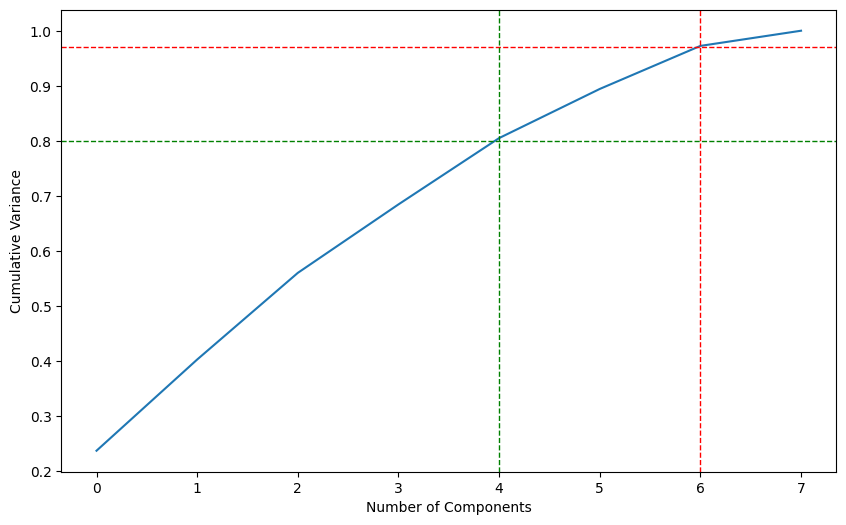

In [ ]:
# Plotting the data
fig = plt.figure(figsize = (10,6))
plt.plot(cvr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
# Draw lines to illustrate vertical and horizontal limits
plt.axhline(y = 0.97, color='red', linestyle='dashed', linewidth=1)
plt.axvline(x = 6 , color='red', linestyle='dashed', linewidth=1)
plt.axhline(y = 0.80, color='green', linestyle='dashed', linewidth=1)
plt.axvline(x = 4, color='green', linestyle='dashed', linewidth=1)

In [ ]:
 # PCA with 4 components
n_components = 4  # Number of components to retain
pca_4 = PCA(n_components=n_components)
X_pca = pca_4.fit_transform(X_train_scaled)

# Analyze Principal Components
# Create a DataFrame to store the loadings (coefficients) of each feature on each component
loadings_df = pd.DataFrame(pca_4.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(n_components)])

# Display the loadings DataFrame to understand which original features contribute most to each component
print("Loadings (Coefficients) of Each Feature on Each Principal Component:")
loadings_df

Loadings (Coefficients) of Each Feature on Each Principal Component:


,car_colour,car_brand,car_model,body_type,crossover,fuel_type,car_age,mileage
PC1,-0.043040,-0.178892,-0.119261,-0.055229,0.033648,-0.334607,0.628372,0.664023
PC2,-0.279098,-0.407258,0.000789,0.624250,0.144556,-0.519524,-0.255018,-0.103536
PC3,0.033301,0.532635,0.732359,0.327861,0.174544,-0.078970,0.119728,0.142520
PC4,0.472007,-0.040289,-0.148685,-0.086262,0.859665,-0.055811,-0.045492,-0.042775


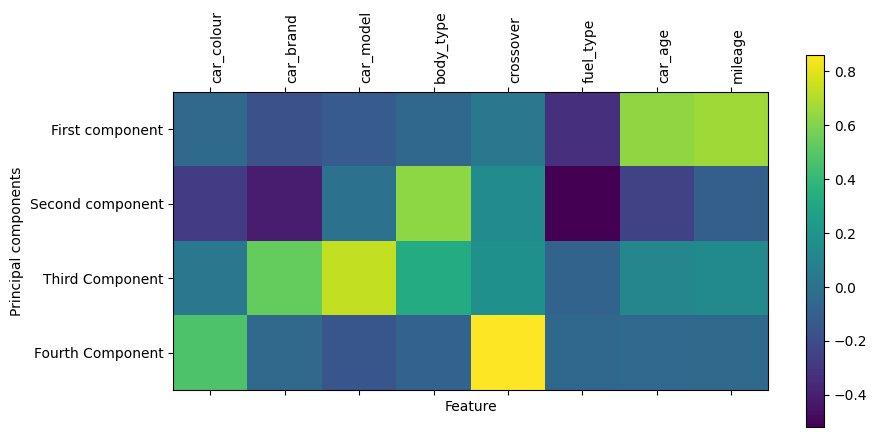

In [ ]:
# Show contribution of each feature on each component
plt.matshow(pca_4.components_, cmap='viridis')
plt.yticks([0, 1, 2, 3], ["First component", "Second component", "Third Component", "Fourth Component"])
plt.colorbar()
plt.xticks(range(len(X.columns)),
           X.columns, rotation=90, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

# Comment:
1. Explained Variance:
*  Top 2 Components: Account for ~40% of the variance.
* Top 5 Components: Account for ~80% of the variance.
* Suggests that PCA significantly reduces dimensionality while retaining most information.
2. Loadings:

* PC1: Strong contributions from car_age and mileage indicate these dominate overall price variations.
* PC2: High coefficients for body_type and car_brand imply secondary dimensions represent categorical impacts.
* PC3: Emphasizes car_model, revealing unique variations not captured in PC1 and PC2.

# 4.0 Model Selection , Building , Training, Evaluation

In [ ]:
#Model Selection , Building , Training, Evaluation
best_params = tune_models(X_train_scaled, y_train)

# Evaluating models
evaluation_output = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, best_params)

# Check the number of returned values
if isinstance(evaluation_output, tuple) and len(evaluation_output) == 2:
    results_df, predictions = evaluation_output
elif isinstance(evaluation_output, tuple):
    results_df, predictions = evaluation_output[:2]  # Extract the first two values
else:
    raise ValueError("Unexpected return format from evaluate_models function.")

# Displaying results
print("\nBest Parameters for Each Model:")
for model, params in best_params.items():
    print(f"{model}: {params}")

print("\nModel Performance:")
print(results_df)

# Example predictions
actual_vs_predicted = pd.DataFrame({
    'Actual': y_test[:10],
    'Predicted_LinearRegression': predictions['LinearRegression'][:10],
    'Predicted_RandomForest': predictions['RandomForest'][:10],
    'Predicted_XGBoost': predictions['XGBoost'][:10],
})
print("\nActual vs Predicted (Sample):")
print(actual_vs_predicted)


Best parameters for LinearRegression: {}
Best parameters for RandomForestRegressor: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for XGBRegressor: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Evaluating LinearRegression...
Evaluating RandomForest...
Evaluating XGBoost...

Best Parameters for Each Model:
LinearRegression: {}
RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Model Performance:
              Model  Train R2   Test R2
2           XGBoost  0.907583  0.868468
1      RandomForest  0.980402  0.850564
0  LinearRegression  0.467682  0.458997

Actual vs Predicted (Sample):
        Actual  Predicted_LinearRegression  Predicted_RandomForest  \
221990    6599                 6547.364464                 6783.18   
81239     9000                12845.773367                 8515.57   
271339    7350                12481.610913            

# Comment:

1. **Hyperparameter Optimization Results:**

* **Linear Regression**: No tunable parameters; uses the default model.
* **Random Forest**: Best parameters suggest minimal pruning (max_depth=None) and a robust ensemble size (n_estimators=100).
* **XGBoost**: Optimal parameters include a learning rate of 0.2 and max
depth of 5 for balance between accuracy and generalization.

2. **Performance Comparison:**
* XGBoost: Best test performance with R² = 0.87, indicating strong generalization.
* Random Forest: Slightly overfits, with a higher train R² but lower test R².
* Linear Regression: Performs poorly due to its inability to capture nonlinear relationships in the data.

3. **Actual vs. Predicted Values:**
*  XGBoost predictions closely match actual values, especially for mid-range prices.
* Random Forest predictions are competitive but show some discrepancies in outlier cases.
* Linear Regression struggles with accurate predictions, as seen in its higher residuals.


# 5.0 Model Interpretation

 96%|=================== | 4708/4889 [00:16<00:00]       

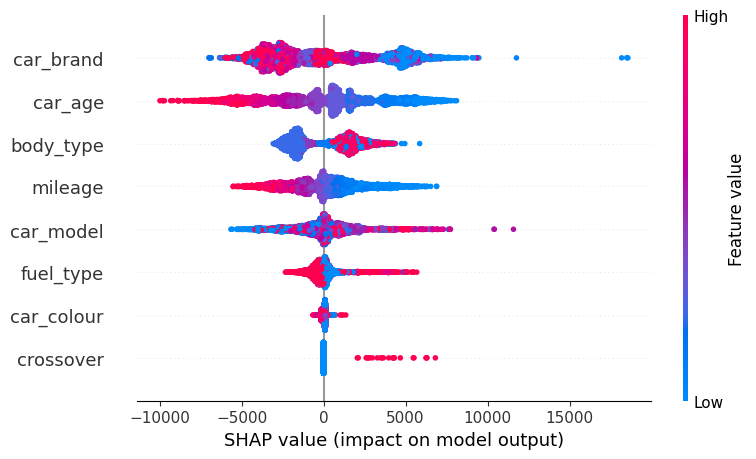

In [ ]:
# SHAP and Feature Importance
for model_name, params in best_params.items():
    if model_name == 'XGBoost':
        # Initialize and fit the model
        model = XGBRegressor(**params, random_state=42)
        model.fit(X_train, y_train)

        # Use SHAP to explain the model
        explainer = shap.Explainer(model, X_train)  # Initialize the explainer
        shap_values = explainer(X_test)  # Compute SHAP values for the test set

        # Visualize the SHAP values
        shap.summary_plot(shap_values, X_test)  # Summary plot
      #  shap.force_plot(shap_values)  # Force plot (optional)


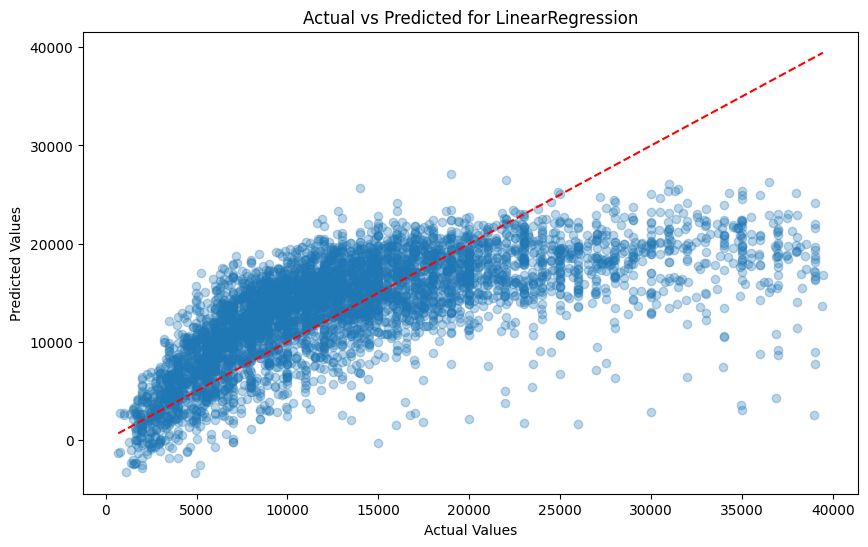

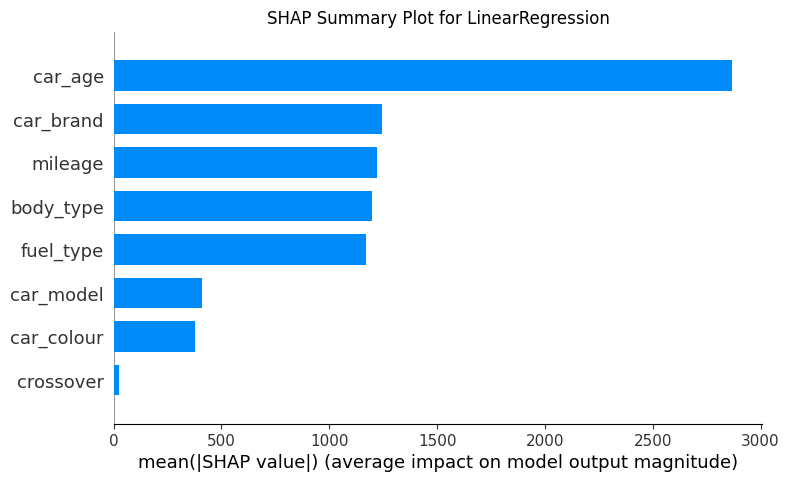

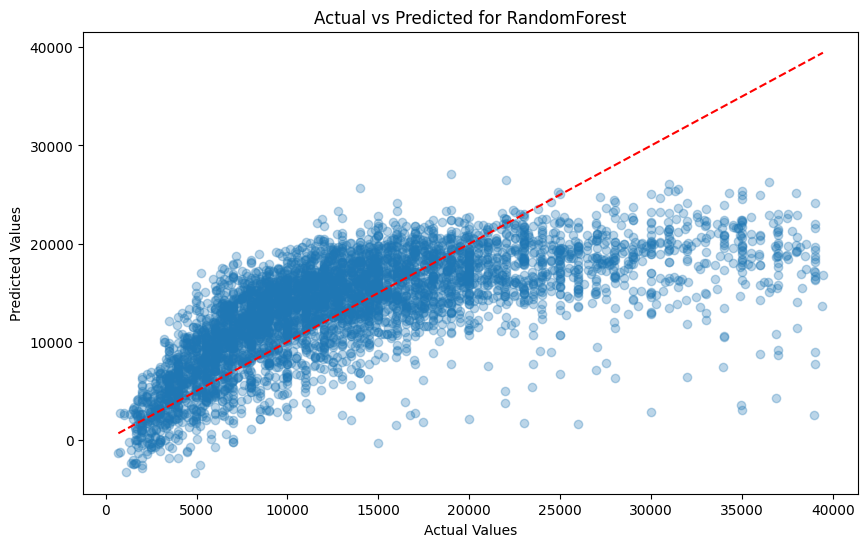

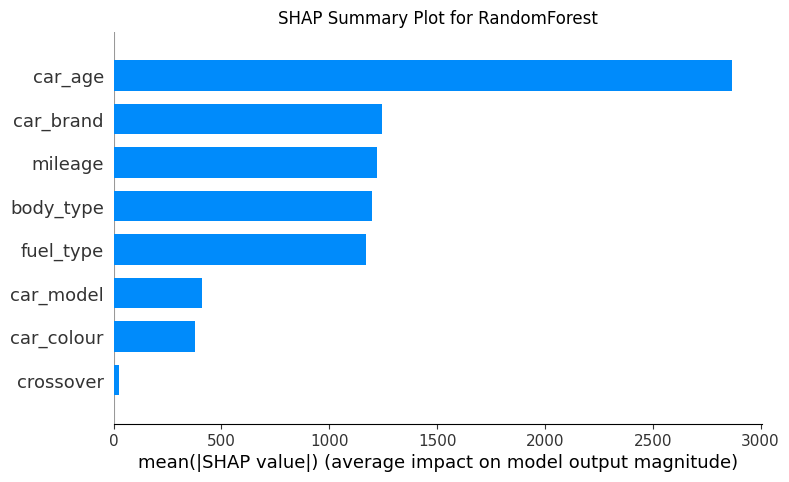

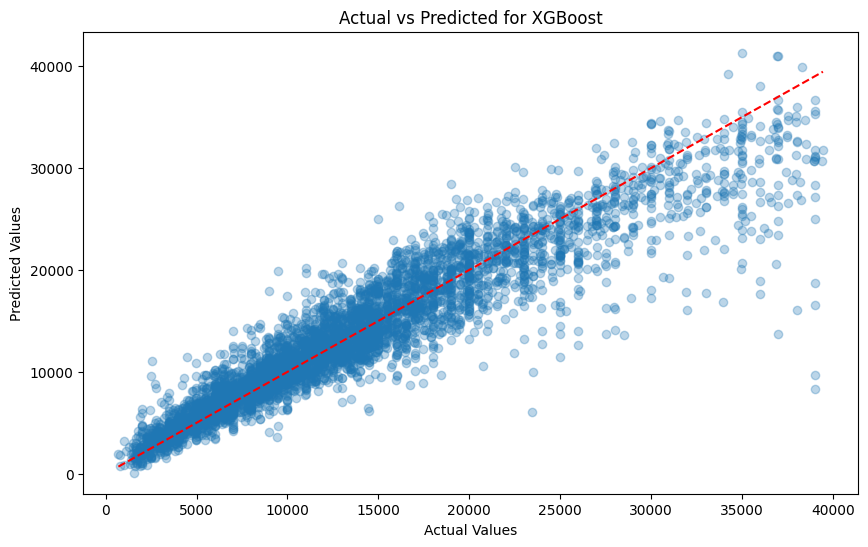

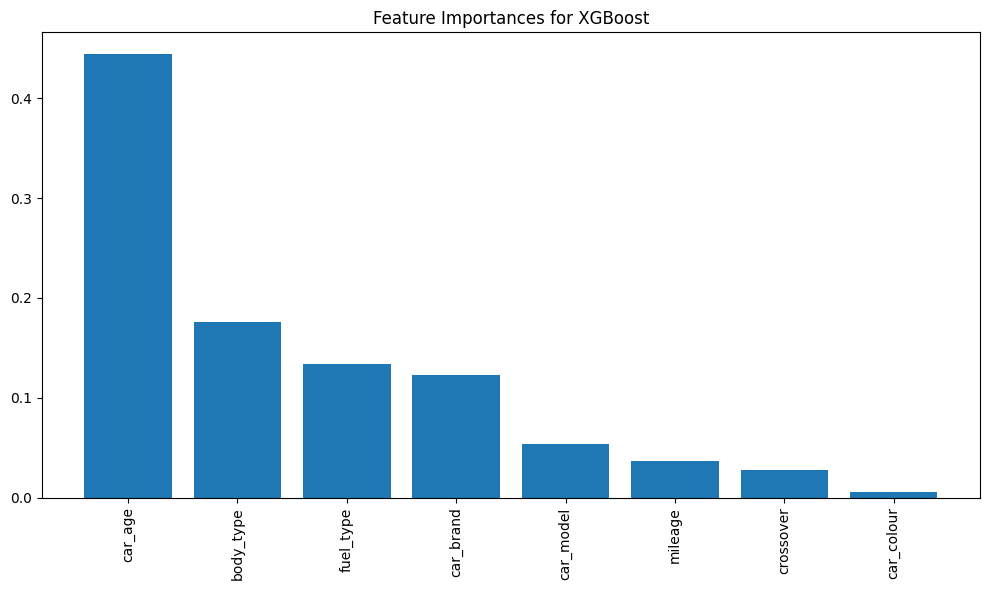

 99%|===================| 4863/4889 [00:17<00:00]       

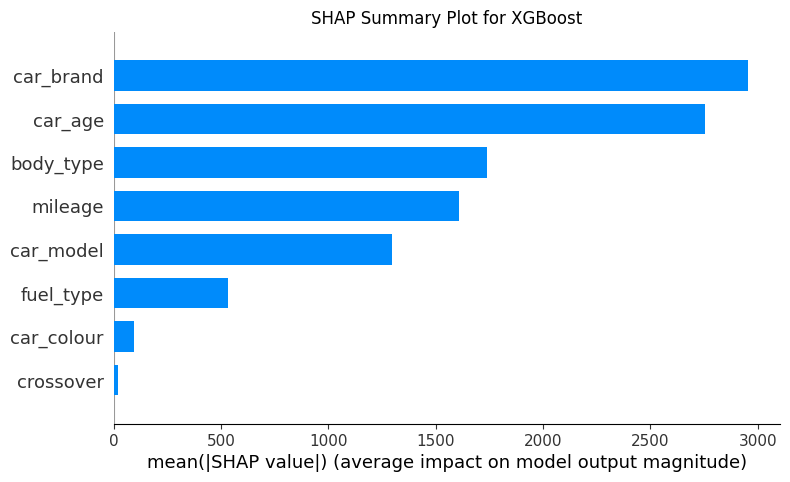

In [ ]:
# Initialize SHAP visualizations
shap.initjs()

# Loop through each model
for model_name, params in best_params.items():
    if model_name == 'LinearRegression':
        model = LinearRegression(**params)
  #  elif model_name == 'RandomForest':
   #     model = RandomForestRegressor(**params, random_state=42)
    elif model_name == 'XGBoost':
        model = XGBRegressor(**params, random_state=42)

    # Fit the model
    model.fit(X_train, y_train.values.ravel())

    # Predict on test set
    y_pred = model.predict(X_test)

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.show()

    # Feature Importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances for {model_name}')
        plt.bar(range(X_train.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

    # SHAP explanations
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # SHAP summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot for {model_name}')
    plt.show()

    # SHAP dependence plot for the most important feature
    #shap.dependence_plot(np.argmax(importances), shap_values.values, X_test, show=False)
    #plt.title(f'SHAP Dependence Plot for {model_name}')
    #plt.show()


# Comment:

**SHAP Summary for All Models:**
*  Key Features Across Models:
* Top Features: car_brand, car_age, body_type, mileage.
* These features consistently influence predictions across all models, validating their importance in vehicle valuation.
* Comparison:

* XGBoost emphasizes car_brand as the dominant factor, reflecting brand-driven price disparities.
* car_age holds consistent importance, with older cars generally valued lower.
* mileage and body_type impact valuations based on wear-and-tear and utility preferences.

* **SHAP Summary Insights:**

* Feature Rankings:

* XGBoost prioritizes categorical features (car_brand, body_type) more than Random Forest or Linear Regression.
* Linear Regression’s rankings are flatter, reflecting its inability to capture complex interactions.
* **SHAP Values:**

* XGBoost yields the most interpretable insights, with clear differentiation between feature impacts.
* Linear Regression shows lower SHAP values due to its limited predictive capacity.


# Conclusion and Recommendations:

1. Feature Engineering and Selection:
* KBest and PCA effectively highlight the most critical features while reducing complexity. Focus on car_age, mileage, and car_brand for future iterations.
2. Model Performance:

* XGBoost is the clear winner for accuracy and interpretability.
* Random Forest is competitive but slightly overfits. Fine-tune its parameters further.
* Linear Regression is not suitable for this dataset due to its inability to model nonlinearity.
3. Interpretability with SHAP:

* XGBoost's SHAP plots provide actionable insights, making it ideal for explaining predictions to stakeholders.
* Consider refining SHAP dependence plots to analyze interactions between car_age and mileage.
